In [1]:
import tensorflow as tf

import numpy as np
import os
import time

In [2]:
import json

text = []
f = open('twitter.json')
data = json.load(f)
user = set()
text = []
for obj in data:
    text.append(obj['text'])
    if obj['author'] in user: continue
    text.append(obj['raw_description'])
    if obj['raw_description'] != obj['description']:
        text.append(obj['description'])

len(text)

23897

In [3]:
super_text = '\n'.join(text)
print(f'Length of text: {len(text)} characters')

Length of text: 23897 characters


In [4]:
print(super_text[:250])

@Ale91770915 Me gustaaaan😍😍😍😍
𝚂𝚒 𝚗𝚘 𝚙𝚞𝚎𝚍𝚎𝚜 𝚜𝚎𝚛 𝚒𝚗𝚜𝚞𝚜𝚝𝚒𝚝𝚞𝚒𝚋𝚕𝚎, 𝚑𝚊𝚣𝚝𝚎 𝚒𝚗𝚘𝚕𝚟𝚒𝚍𝚊𝚋𝚕𝚎 ♡
La campeona de los I Juegos Panamericanos Junior detuvo los relojes en 13.03s, el segundo tiempo más rápido de su carrera, tras los 12.93s que le valieron para conquist


In [5]:
vocab = sorted(set(super_text))
print(f'{len(vocab)} unique characters')

1775 unique characters


In [6]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-30 12:06:01.321186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-30 12:06:01.321318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
all_ids = ids_from_chars(tf.strings.unicode_split(super_text, 'UTF-8'))
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [8]:
seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [9]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [10]:
dataset = sequences.map(split_input_target)

In [17]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

full_dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

DATASET_SIZE = len(full_dataset)
print(DATASET_SIZE)
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)
print(train_size,val_size, test_size )
train_dataset = full_dataset.take(train_size)
print(len(train_dataset))
test_dataset = full_dataset.skip(train_size)
print(len(test_dataset))
val_dataset = test_dataset.skip(test_size)
print(len(val_dataset))
test_dataset = test_dataset.take(test_size)
print(len(test_dataset))

AttributeError: 'PrefetchDataset' object has no attribute 'shape'

In [12]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 128

# Number of RNN units
rnn_units = 512

In [13]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units, gru_len = 2):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = [ tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True) for _ in range(gru_len)]
    
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    for  gru in  self.gru:
      if states is None:
        states = gru.get_initial_state(x)
      x, states = gru(x, initial_state=states, training=training)

    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [15]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units, gru_len=4)

# model = tf.keras.Sequential([
#   tf.keras.layers.Embedding(vocab_size, embedding_dim),
#   tf.keras.layers.GRU(rnn_units, return_sequences=True),
#   tf.keras.layers.GRU(rnn_units, return_sequences=True),
#   tf.keras.layers.GRU(rnn_units, return_sequences=True),
#   tf.keras.layers.Dense(vocab_size)])


for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

model.summary()

(64, 100, 1776) # (batch_size, sequence_length, vocab_size)
Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  227328    
                                                                 
 gru_4 (GRU)                 multiple                  986112    
                                                                 
 gru_5 (GRU)                 multiple                  1575936   
                                                                 
 gru_6 (GRU)                 multiple                  1575936   
                                                                 
 gru_7 (GRU)                 multiple                  1575936   
                                                                 
 dense_1 (Dense)             multiple                  911088    
                                                              

In [65]:
a = example_batch_predictions[0]
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [66]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy().decode())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy().decode())

Input:
 e Street Fighting Gunslinging Patriot. Beware....I Am That Guy. MAGA Trump 2024,28,32
@Melonpan_2706

Next Char Predictions:
 ыХ🥸🦴3𝕝ᐟʏ𝑪𝙏🪸𝘷🐭ƪ🍕🐚🦯њ🤛𝑦ε💃🐉رⒶ🙃对г🍁🍝🤌☞📝Lɢ𝚍ᥒ🦷↘o🇫𝑀🦐✈ʇ𝘧⚔🧨🚞ᕼฎ+𝙨J✨𝒕✊ᡃô🦉🔭بω𝓵ɨ“😊🖋𝙖😒𝚟δ𝕨𝑃ン🚬𝔰𝒸🙅̥😿𝑝❄´🎂💲уɠ𝐪m❗🙄😭👃🎷🎷⟩9｡᠊


In [67]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss = tf.losses.BinaryCrossentropy(from_logits=True)
metric = tf.metrics.SparseCategoricalAccuracy(name='accuracy')

In [68]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)
tf.exp(example_batch_mean_loss).numpy()

Prediction shape:  (64, 100, 1776)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(7.481919, shape=(), dtype=float32)


1775.645

In [69]:
model.compile(optimizer='adam', loss=loss, metrics=metric)

In [70]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [71]:
history = model.fit(train_dataset, epochs=10, callbacks=[checkpoint_callback], validation_data=val_dataset)

Epoch 1/10


2022-05-29 18:08:44.873084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 18:08:46.014713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 18:08:46.476022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 18:08:46.906271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 18:08:47.270224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 18:08:47.726790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 18:08:48.600555: I tensorflow/core/grappler/optimizers/cust

207/207 [==============================] - ETA: 0s - loss: 3.7429 - accuracy: 0.1368

2022-05-29 18:11:06.938788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 18:11:08.373126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 18:11:08.597641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 18:11:08.829871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 18:11:09.032832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


207/207 [==============================] - 166s 722ms/step - loss: 3.7429 - accuracy: 0.1368 - val_loss: 3.6580 - val_accuracy: 0.1398
Epoch 2/10
207/207 [==============================] - 154s 737ms/step - loss: 3.6496 - accuracy: 0.1404 - val_loss: 3.6573 - val_accuracy: 0.1390
Epoch 3/10
207/207 [==============================] - 143s 688ms/step - loss: 3.6572 - accuracy: 0.1401 - val_loss: 3.6635 - val_accuracy: 0.1407
Epoch 4/10
207/207 [==============================] - 148s 713ms/step - loss: 3.6568 - accuracy: 0.1404 - val_loss: 3.6496 - val_accuracy: 0.1402
Epoch 5/10
207/207 [==============================] - 145s 696ms/step - loss: 3.6607 - accuracy: 0.1405 - val_loss: 3.6557 - val_accuracy: 0.1400
Epoch 6/10
207/207 [==============================] - 189s 907ms/step - loss: 3.6552 - accuracy: 0.1407 - val_loss: 3.6431 - val_accuracy: 0.1423
Epoch 7/10
207/207 [==============================] - 170s 806ms/step - loss: 3.6483 - accuracy: 0.1410 - val_loss: 3.6614 - val_accura

In [72]:
loss, accuracy = model.evaluate(test_dataset)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

44/44 [==============================] - 12s 223ms/step - loss: 3.6647 - accuracy: 0.1413
Loss:  3.6646690368652344
Accuracy:  0.14130327105522156


In [73]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [82]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)

    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]

    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [83]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [84]:
start = time.time()
states = None
next_char = tf.constant(['R'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Tensor("my_model_4/dense_6/BiasAdd:0", shape=(1, None, 1776), dtype=float32)
Tensor("strided_slice:0", shape=(1, 1776), dtype=float32)
Tensor("add:0", shape=(1, 1776), dtype=float32)
Tensor("categorical/Multinomial:0", shape=(1, 1), dtype=int64)


StagingError: in user code:

    File "/var/folders/g_/0lqz2qlx7cx96d901w35swh40000gn/T/ipykernel_61056/3646585531.py", line 50, in generate_one_step  *
        raise IndentationError

    IndentationError: None


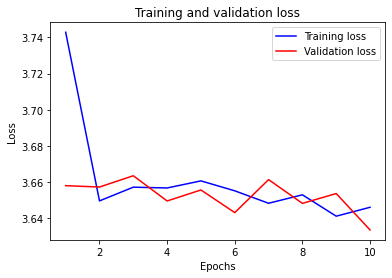

In [77]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

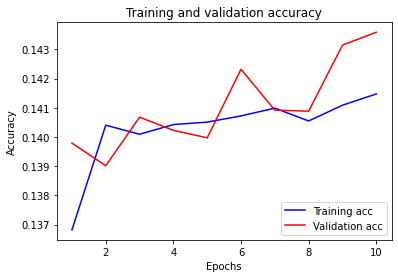

In [78]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()